In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
import matplotlib.colors as mcolors
from matplotlib import cm
from highlight_text import fig_text, ax_text
import matplotlib.gridspec as gridspec
import pylab as p
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
import pandas as pd
import matplotlib


from PIL import Image

from mplsoccer import FontManager
URL3 = 'https://github.com/VanillaandCream/Catamaran-Tamil/blob/master/Fonts/Catamaran-Medium.ttf?raw=true'
catamaran2 = FontManager(URL3)
URL = 'https://github.com/google/fonts/blob/main/ofl/fjallaone/FjallaOne-Regular.ttf?raw=true'
robotto_regular = FontManager(URL)
URL2 = 'https://github.com/VanillaandCream/Catamaran-Tamil/blob/master/Fonts/Catamaran-ExtraBold.ttf?raw=true'
catamaran = FontManager(URL2)

In [3]:
df = pd.read_csv('Todos los eventos CopaLPF2024 Fecha 14.csv')
df_xGs = df[['round','match_id','team','xg', 'goals']].groupby(['round','match_id', 'team'], as_index=False).sum()

In [4]:
df_xGs

,round,match_id,team,xg,goals
0,1,4393553,Defensa y Justicia,0.12,0
1,1,4393553,Godoy Cruz,1.48,2
2,1,4393554,Argentinos Juniors,0.66,1
3,1,4393554,River Plate,1.00,1
4,1,4393555,Deportivo Riestra,0.18,0
...,...,...,...,...,...
387,14,4393728,Godoy Cruz,0.86,0
388,14,4393729,Defensa y Justicia,1.90,1
389,14,4393729,Newell's Old Boys,1.29,0
390,14,4393730,Estudiantes,1.42,2


In [5]:
df_xG_tot = df_xGs.merge(df_xGs, how='inner', on='match_id', suffixes=('', '_other'))
df_xG_tot['xga'] = df_xG_tot['xg_other']
df_xG_tot.drop(['round_other', 'team_other', 'xg_other'], axis=1).drop_duplicates(subset=['match_id', 'team', 'xg', 'xga'])

,round,match_id,team,xg,goals,goals_other,xga
0,1,4393553,Defensa y Justicia,0.12,0,0,0.12
1,1,4393553,Defensa y Justicia,0.12,0,2,1.48
2,1,4393553,Godoy Cruz,1.48,2,0,0.12
3,1,4393553,Godoy Cruz,1.48,2,2,1.48
4,1,4393554,Argentinos Juniors,0.66,1,1,0.66
...,...,...,...,...,...,...,...
779,14,4393729,Newell's Old Boys,1.29,0,0,1.29
780,14,4393730,Estudiantes,1.42,2,2,1.42
781,14,4393730,Estudiantes,1.42,2,1,1.05
782,14,4393730,Lanus,1.05,1,2,1.42


In [6]:
merged_df = df_xGs.merge(df_xGs, how='inner', on='match_id', suffixes=('', '_other'))
merged_df['xga'] = merged_df['xg_other']
merged_df.drop(['round_other', 'xg_other', 'goals_other'], axis=1, inplace=True)

# Eliminar filas duplicadas
result_df = merged_df[merged_df['team'] != merged_df['team_other']]
result_df = result_df.drop_duplicates(subset=['match_id', 'team'])

# Limpiar y mostrar el resultado
result_df.drop(['team_other'], axis=1, inplace=True)
result_df = result_df.reset_index(drop=True)

In [7]:
df_xG_tot = result_df

In [8]:
df_xG_tot.columns

Index(['round', 'match_id', 'team', 'xg', 'goals', 'xga'], dtype='object')

In [9]:
df_test = df_xG_tot[df_xG_tot['team'] == 'Defensa y Justicia']

In [10]:
df_test[['xg', 'xga']]

,xg,xga
0,0.12,1.48
31,1.22,0.77
66,0.71,0.93
111,0.25,2.04
124,2.06,1.28
143,0.89,1.23
188,1.70,0.70
210,0.67,1.80
251,0.00,0.00
272,1.54,0.84


In [11]:
df_test['xg'].rolling(5, min_periods=0).mean()

0      0.120000
31     0.670000
66     0.683333
111    0.575000
124    0.872000
143    1.026000
188    1.122000
210    1.114000
251    1.064000
272    0.960000
300    0.782000
328    0.510000
348    0.702000
388    1.082000
Name: xg, dtype: float64

In [12]:
df_test['xg'].rolling(5, min_periods=0).sum()

0      0.12
31     1.34
66     2.05
111    2.30
124    4.36
143    5.13
188    5.61
210    5.57
251    5.32
272    4.80
300    3.91
328    2.55
348    3.51
388    5.41
Name: xg, dtype: float64

In [13]:
def get_xG_rolling_data(team_id, window=10, data=df_xG_tot):
    '''
    This function returns xG rolling average figures for a specific team.
    '''
    df_roll = data.copy()
    df_roll = df_roll[df_roll['team'] == team_id].reset_index(drop=True)
    df_roll['rolling_xG_corr'] = df_roll['xg'].rolling(window, min_periods=0).mean()
    df_roll['rolling_xG_ag'] = df_roll['xga'].rolling(window, min_periods=0).mean()
    df_roll['rolling_diff'] = df_roll['rolling_xG_corr'] - df_roll['rolling_xG_ag']
    return df_roll

def get_xG_interpolated_df(team_id, window=10, data=df_xG_tot):
    # --- Get the xG rolling df
    df_xG = get_xG_rolling_data(team_id, window, data)
    # -- Create interpolated series
    df_xG['match_number'] = df_xG.index
    X_aux = df_xG.match_number.copy()
    X_aux.index = X_aux * 10 # 9 aux points in between each match
    last_idx = X_aux.index[-1] + 1
    X_aux = X_aux.reindex(range(last_idx))
    X_aux = X_aux.interpolate()
    # --- Aux series for the xG created (Y_for)
    Y_for_aux = df_xG.rolling_xG_corr.copy()
    Y_for_aux.index = Y_for_aux.index * 10
    last_idx = Y_for_aux.index[-1] + 1
    Y_for_aux = Y_for_aux.reindex(range(last_idx))
    Y_for_aux = Y_for_aux.interpolate()
    # --- Aux series for the xG conceded (Y_ag)
    Y_ag_aux = df_xG.rolling_xG_ag.copy()
    Y_ag_aux.index = Y_ag_aux.index * 10
    last_idx = Y_ag_aux.index[-1] + 1
    Y_ag_aux = Y_ag_aux.reindex(range(last_idx))
    Y_ag_aux = Y_ag_aux.interpolate()
    # --- Aux series for the rolling difference in xG
    Z_diff_aux = df_xG.rolling_diff.copy()
    Z_diff_aux.index = Z_diff_aux.index * 10
    last_idx = Z_diff_aux.index[-1] + 1
    Z_diff_aux = Z_diff_aux.reindex(range(last_idx))
    Z_diff_aux = Z_diff_aux.interpolate()
    # -- Create the aux dataframe
    df_aux = pd.DataFrame({
        'X': X_aux,
        'Y_for': Y_for_aux,
        'Y_ag': Y_ag_aux,
        'Z': Z_diff_aux
    })
    return df_aux

def colorFader(c1,c2,mix=0): #fade (linear interpolate) from color c1 (at mix=0) to c2 (mix=1)
    c1=np.array(mcolors.to_rgb(c1))
    c2=np.array(mcolors.to_rgb(c2))
    return mcolors.to_hex((1-mix)*c1 + mix*c2)


def plot_xG_gradient(ax, team_id, window=10, data=df_xG_tot):
    # -- Get the data
    df_xg = get_xG_rolling_data(team_id, window, data)
    df_aux_xg = get_xG_interpolated_df(team_id, window, data)
    # Specify the axes limits
    ax.set_ylim(0,2)
    ax.set_xlim(-0.5,df_xg.shape[0])
    ax.grid(ls='--', color='lightgrey')
    # -- Select the colors
    color_2 = '#00ff85'
    color_1 = '#38003c'

    ax.plot(df_xg.index, df_xg['rolling_xG_corr'], color=color_2,zorder=4)
    ax.plot(df_xg.index, df_xg['rolling_xG_ag'], color=color_1,zorder=4)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    #ax.fill_between(x=[-0.5,30], y1=ax.get_ylim()[0], y2=ax.get_ylim()[1], alpha=0.1, color='black', ec='None',zorder=2)
    vmin = df_xg['rolling_diff'].min()
    vmax = df_xg['rolling_diff'].max()
    vmax = max(abs(vmin), abs(vmax))
    vmin = -1*vmax
    for i in range(0, len(df_aux_xg['X']) - 1):
        ax.fill_between(
            [df_aux_xg['X'].iloc[i], df_aux_xg['X'].iloc[i+1]],
            [df_aux_xg['Y_for'].iloc[i], df_aux_xg['Y_for'].iloc[i + 1]],
            [df_aux_xg['Y_ag'].iloc[i], df_aux_xg['Y_ag'].iloc[i + 1]],
            color=colorFader(color_1, color_2, mix=((df_aux_xg['Z'].iloc[i] - vmin)/(vmax - vmin))),
            zorder=3, alpha=0.3
        )
    for x in [38, 38*2]:
        ax.plot([x,x],[ax.get_ylim()[0], ax.get_ylim()[1]], color='black', alpha=0.35, zorder=2, ls='dashdot', lw=0.95)

    return ax

In [14]:
get_xG_rolling_data('Defensa y Justicia',5, df_xG_tot)

,round,match_id,team,xg,goals,xga,rolling_xG_corr,rolling_xG_ag,rolling_diff
0,1,4393553,Defensa y Justicia,0.12,0,1.48,0.120000,1.480,-1.360000
1,2,4393714,Defensa y Justicia,1.22,3,0.77,0.670000,1.125,-0.455000
2,3,4393541,Defensa y Justicia,0.71,3,0.93,0.683333,1.060,-0.376667
3,4,4393577,Defensa y Justicia,0.25,0,2.04,0.575000,1.305,-0.730000
4,5,4393607,Defensa y Justicia,2.06,1,1.28,0.872000,1.300,-0.428000
5,6,4393582,Defensa y Justicia,0.89,1,1.23,1.026000,1.250,-0.224000
6,7,4393593,Defensa y Justicia,1.70,1,0.70,1.122000,1.236,-0.114000
7,8,4393649,Defensa y Justicia,0.67,0,1.80,1.114000,1.410,-0.296000
8,9,4393667,Defensa y Justicia,0.00,1,0.00,1.064000,1.002,0.062000
9,10,4393634,Defensa y Justicia,1.54,2,0.84,0.960000,0.914,0.046000


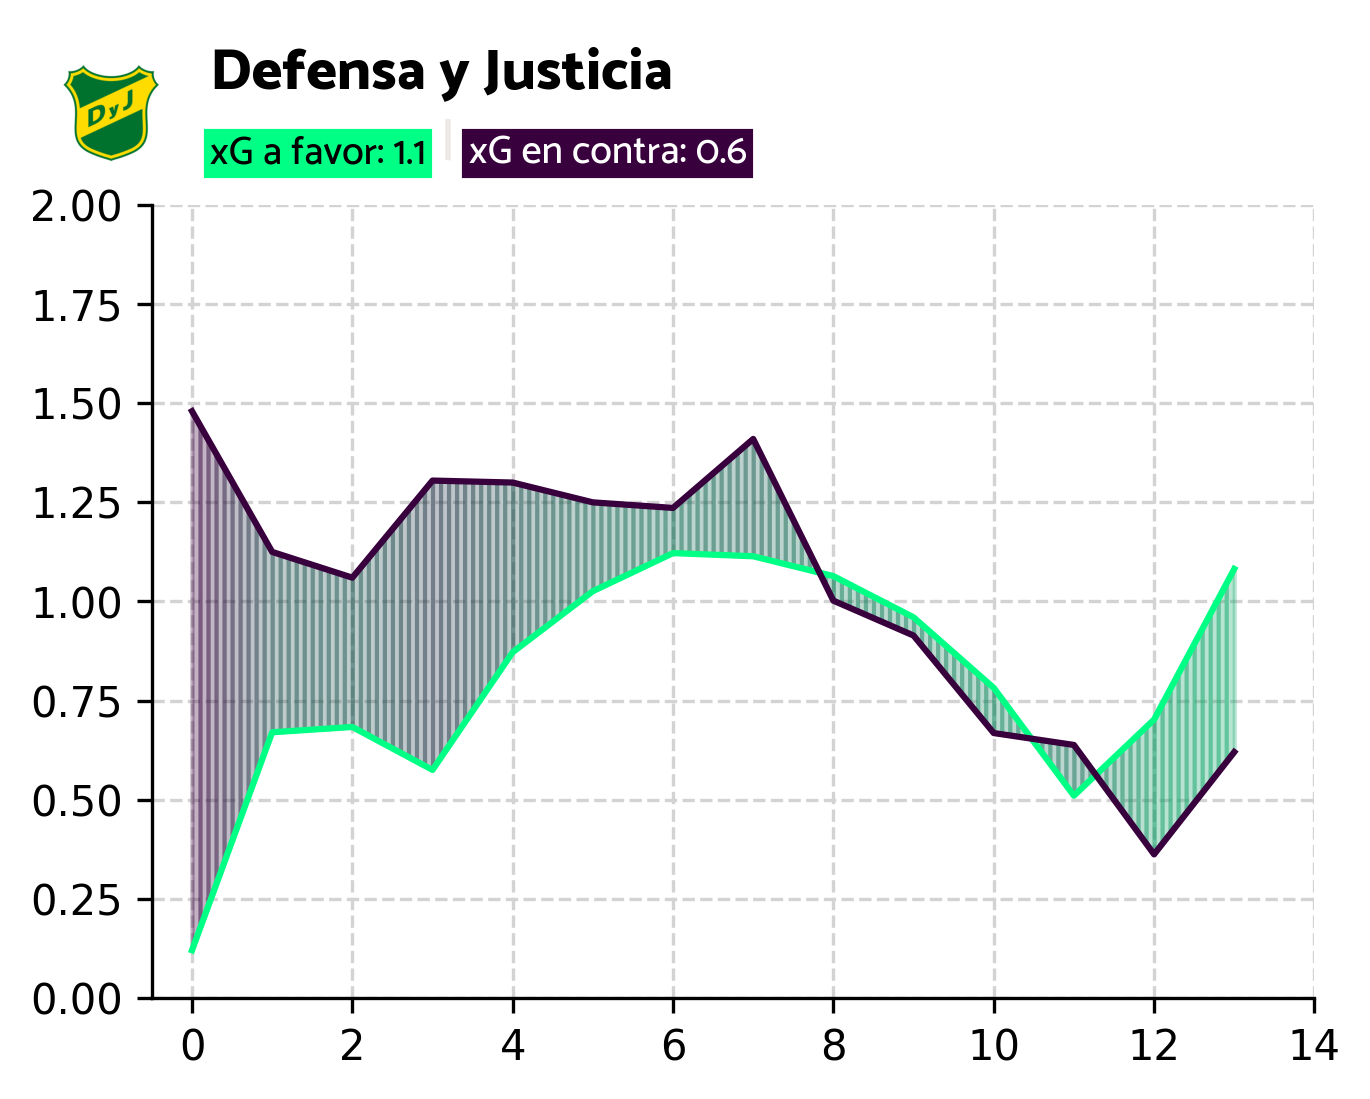

In [15]:
fig = plt.figure(figsize=(5,3.5), dpi=300)
ax = plt.subplot(111)
fig.set_facecolor('white')

teamId = 'Defensa y Jus'

plot_xG_gradient(ax, teamId, 5, df_xG_tot)
df_for_text = get_xG_rolling_data(teamId, 5)
teamName = df_for_text['team'].iloc[0]
xG_for = df_for_text['rolling_xG_corr'].iloc[-1]
xG_ag = df_for_text['rolling_xG_ag'].iloc[-1]
color_2 = '#00ff85'
color_1 = '#38003c'
# -- This was done manually cuz I'm lazy...
if color_1 == '#d1d3d4':
    color_1_t = 'black'
else:
    color_1_t = 'white'
if color_2 == '#97c1e7':
    color_2_t = 'black'
else:
    color_2_t = 'black'
                
ax_text(
                x = 0.05, 
                y = 1.2,
                s = f'<{teamName}>\n<xG a favor: {xG_for:.1f}> <|> <xG en contra: {xG_ag:.1f}>',
                ax = ax, 
                highlight_textprops=[
                    {'weight':'bold', 'font':catamaran.prop},
                    {'size':'9.5', 'bbox': {'edgecolor': color_2, 'facecolor': color_2, 'pad': 1}, 'color': color_2_t}, 
                    {'color':'#EFE9E6'},
                    {'size':'9.5', 'bbox': {'edgecolor': color_1, 'facecolor': color_1, 'pad': 1}, 'color': color_1_t}
                ],
                font = catamaran2.prop, 
                ha = 'left', 
                size = 14, 
                annotationbbox_kw = {'xycoords':'axes fraction'}
            )
logo_ax = fig.add_axes(
    [0.05, .92, .095, .095]
)
club_icon = Image.open(f'/Logos/2/{teamName.lower()}.png')
logo_ax.imshow(club_icon)
logo_ax.axis('off')


In [18]:
df_xG_tot.team.sort_values().unique()[:7]

array(['Argentinos Juniors', 'Atletico Tucuman', 'Banfield',
       'Barracas Central', 'Belgrano', 'Boca Juniors',
       'Central Cordoba de Santiago'], dtype=object)

'\nplt.savefig(\n\t"figures/09262022_epl_xG_rolling_gradient_tr.png",\n\tdpi = 600,\n\tfacecolor = "none",\n\tbbox_inches="tight",\n    edgecolor="none",\n\ttransparent = True\n)'

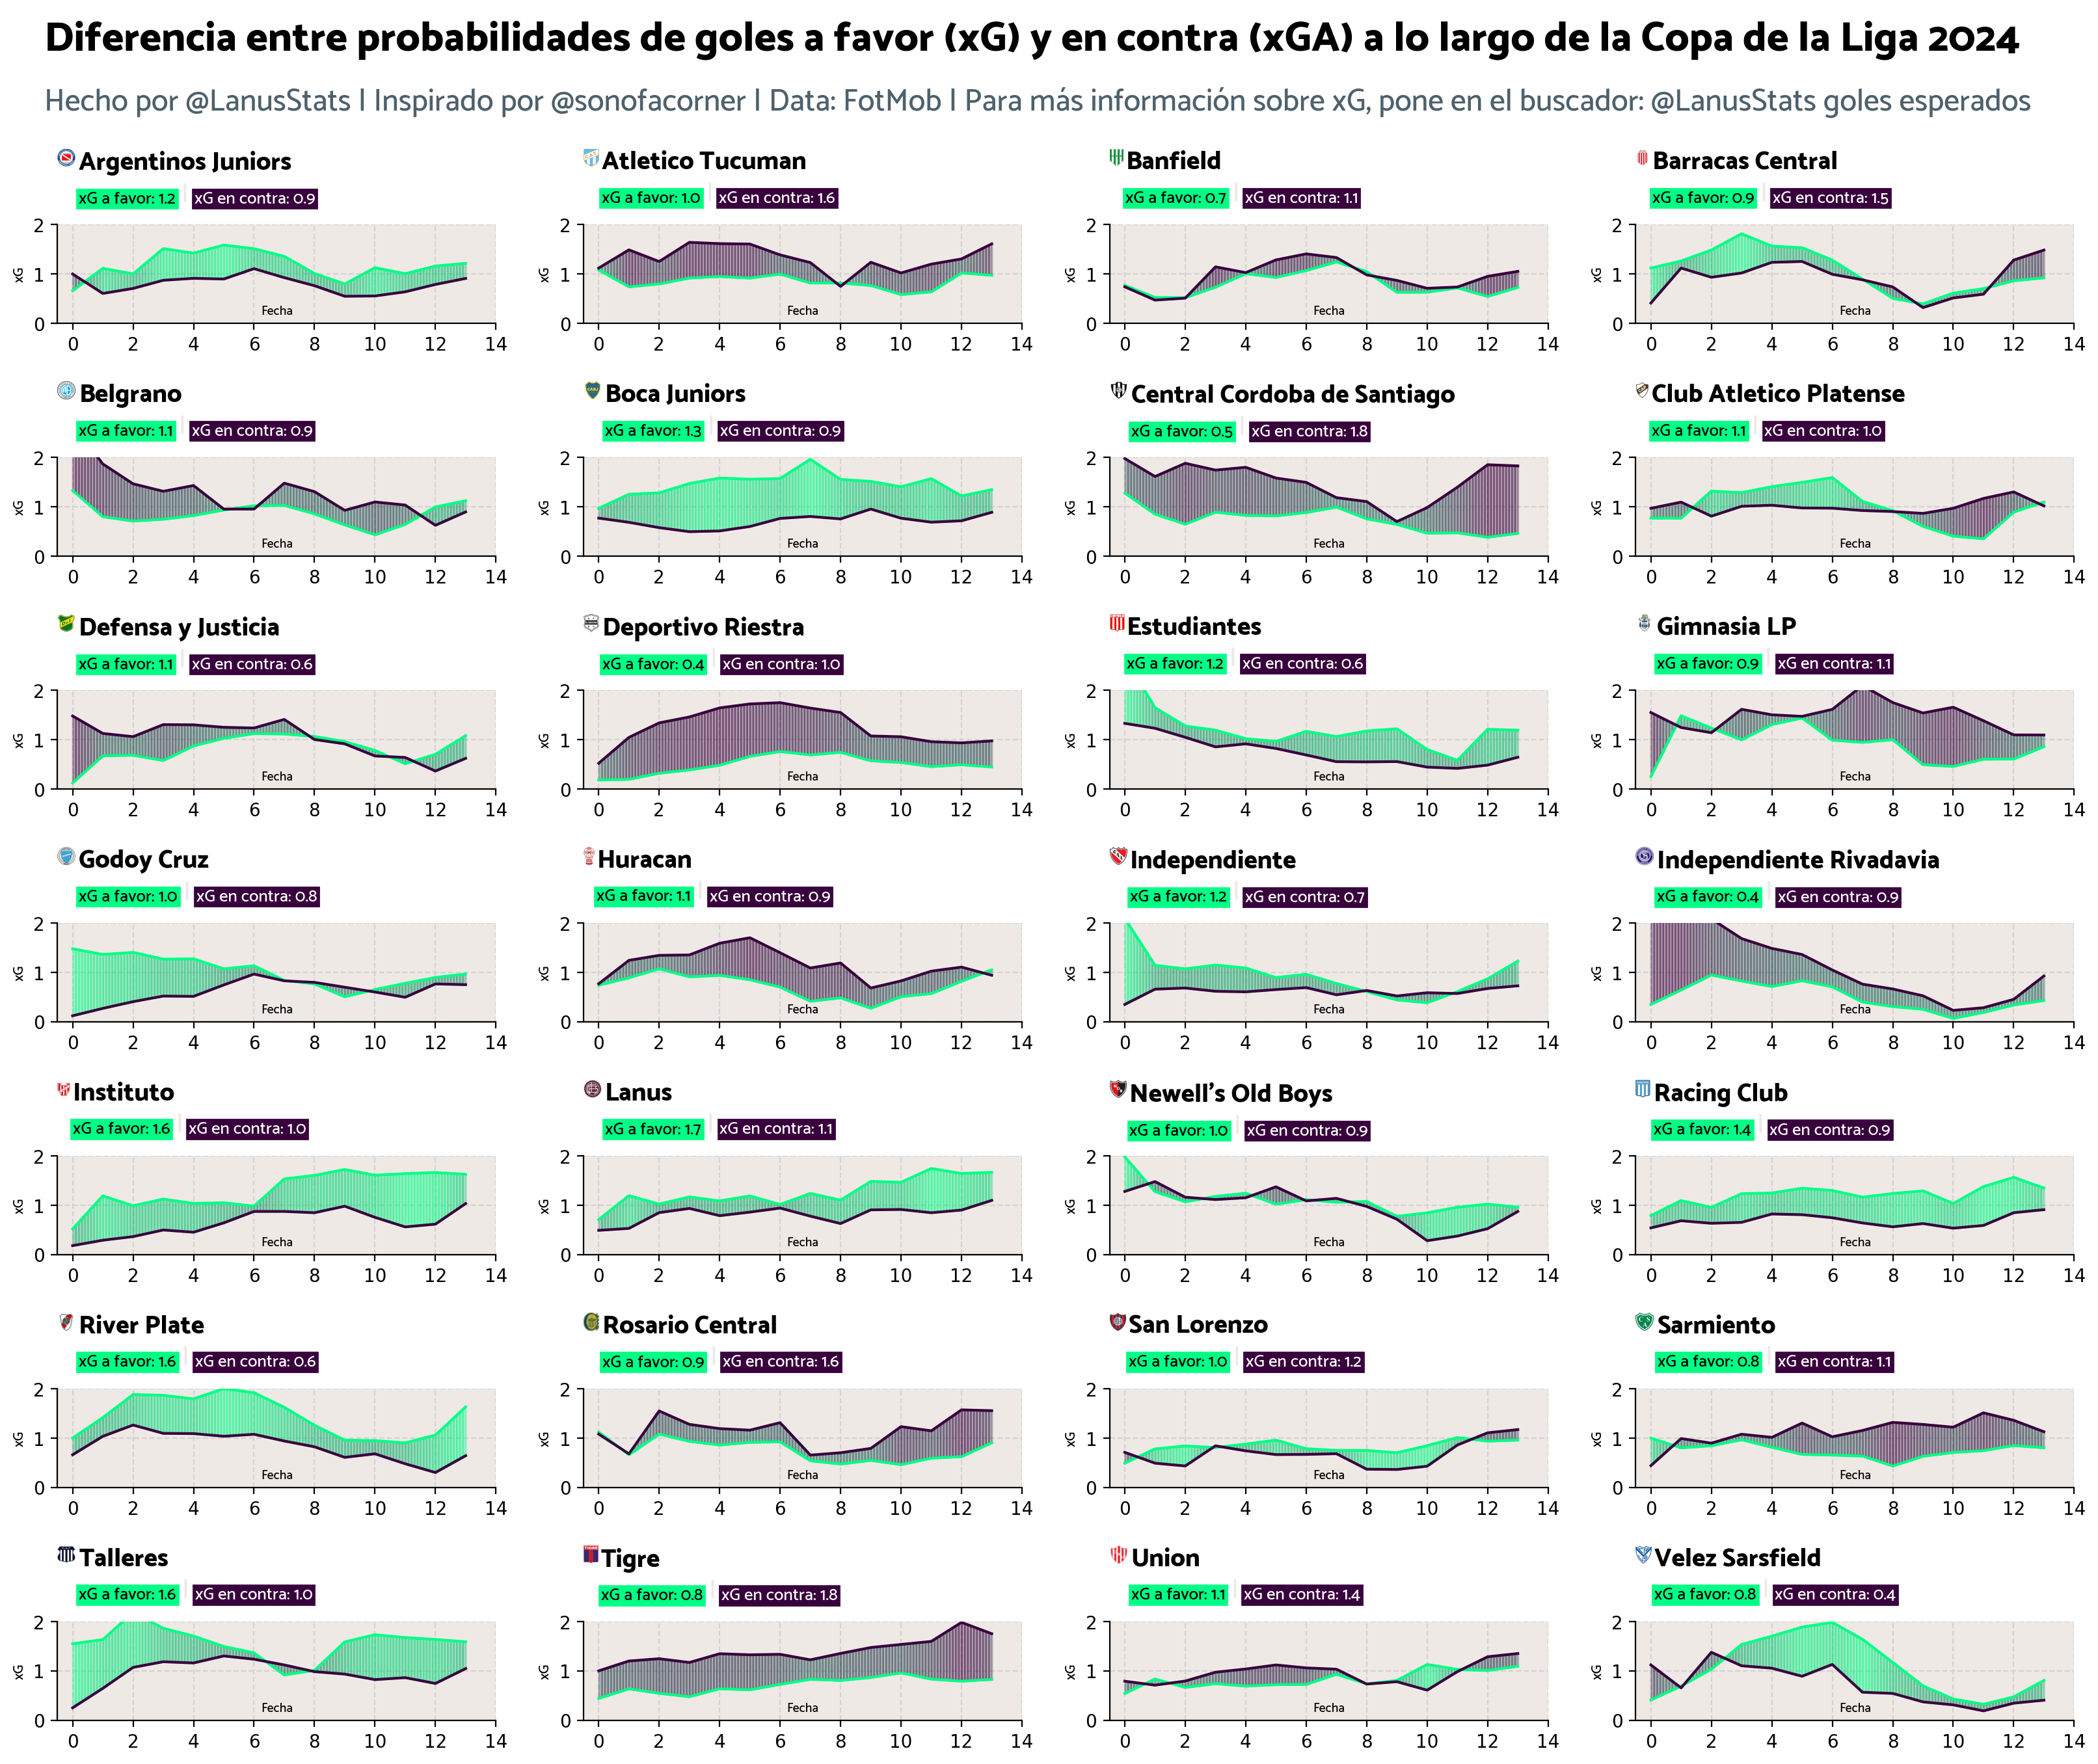

In [17]:
# ---- for path effects
def path_effect_stroke(**kwargs):
    return [path_effects.Stroke(**kwargs), path_effects.Normal()]
pe = path_effect_stroke(linewidth=1.5, foreground="black")
# ----
fig = plt.figure(figsize=(20, 16), dpi = 200)
fig.set_facecolor('white')
nrows = 14 #Numero de equipos * 2
ncols = 4
gspec = gridspec.GridSpec(
    ncols=ncols, nrows=nrows, figure=fig, 
    height_ratios=[(1/nrows)*2.35 if x % 2 != 0 else (1/nrows)/2.35 for x in range(nrows)], hspace=1
)

plot_counter = 0
logo_counter = 0

for row in range(nrows):
    for col in range(ncols):
        if row % 2 != 0: #ploteo grafico
            ax = plt.subplot(
                gspec[row, col],
                facecolor = "#EFE9E6"
            )
            teamId = list(df_xG_tot.team.sort_values().unique())[plot_counter]
            plot_xG_gradient(ax, teamId, 5)
            plt.xlabel('Fecha', size=7, fontproperties=catamaran2.prop, labelpad=-27)
            plt.ylabel('xG', size=8, fontproperties=catamaran2.prop)
                       
            plot_counter += 1
        else: #ploteo logos
            teamId = list(df_xG_tot.team.sort_values().unique())[logo_counter]
            color_2 = '#00ff85'
            color_1 = '#38003c'
            # -- This was done manually cuz I'm lazy...
            if color_1 == '#d1d3d4':
                color_1_t = 'black'
            else:
                color_1_t = 'white'
            if color_2 == '#97c1e7':
                color_2_t = 'black'
            else:
                color_2_t = 'black'
            df_for_text = get_xG_rolling_data(teamId, 5)
            teamName = df_for_text['team'].iloc[0]
            xG_for = df_for_text['rolling_xG_corr'].iloc[-1]
            xG_ag = df_for_text['rolling_xG_ag'].iloc[-1]
            #fotmob_url = 'https://images.fotmob.com/image_resources/logo/teamlogo/'
            logo_ax = plt.subplot(
                gspec[row,col],
                anchor = 'NW', facecolor = '#EFE9E6'
            )
            club_icon = Image.open(f'C:/Users/Federico Rábanos/Documents/lanus stats/Logos/2/{teamName.lower()}.png')
            logo_ax.imshow(club_icon)
            logo_ax.axis('off')
            # -- Add the team name
            ax_text(
                x = 1.2, 
                y = 0.9,
                s = f'<{teamName}>\n<xG a favor: {xG_for:.1f}> <|> <xG en contra: {xG_ag:.1f}>',
                ax = logo_ax, 
                highlight_textprops=[
                    {'weight':'bold', 'font':catamaran.prop},
                    {'size':'9.5', 'bbox': {'edgecolor': color_2, 'facecolor': color_2, 'pad': 1}, 'color': color_2_t}, 
                    {'color':'#EFE9E6'},
                    {'size':'9.5', 'bbox': {'edgecolor': color_1, 'facecolor': color_1, 'pad': 1}, 'color': color_1_t}
                ],
                font = catamaran2.prop, 
                ha = 'left', 
                size = 14, 
                annotationbbox_kw = {'xycoords':'axes fraction'}
            )
            logo_counter += 1

fig_text(
    x=0.12, y=.923, 
    s='Diferencia entre probabilidades de goles a favor (xG) y en contra (xGA) a lo largo de la Copa de la Liga 2024',
    va='bottom', ha='left',  fontproperties=catamaran.prop,
    fontsize=23, color='black'
)
fig_text(
	x=0.12, y=.895, 
    s='Hecho por @LanusStats | Inspirado por @sonofacorner | Data: FotMob | Para más información sobre xG, pone en el buscador: @LanusStats goles esperados',
	va='bottom', ha='left', font= catamaran2.prop,
	size=17, color='#4E616C'
)

plt.savefig(
	"rollingxgs_cdlg24.png",
	dpi = 600,
	facecolor = "#EFE9E6",
	bbox_inches="tight",
    edgecolor="none",
	transparent = False
)